<a href="https://colab.research.google.com/github/harvard-visionlab/psy1410/blob/master/psy1410_rgeirhos_shape_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Shape/Texture Bias using Geirhos' cue-conflict stimuli

# download rgeirhos code and stimuli

In [ ]:
!git clone https://github.com/rgeirhos/texture-vs-shape.git
!mv texture-vs-shape texture_vs_shape
!touch texture_vs_shape/__init__.py
!touch texture_vs_shape/code/__init__.py
!touch texture_vs_shape/code/helper/__init__.py
!sed -i 's/import helper.wordnet_functions as wf/from . import wordnet_functions as wf/g' /content/texture_vs_shape/code/helper/human_categories.py
!sed -i 's/import helper.human_categories as hc/from .helper import human_categories as hc/g' /content/texture_vs_shape/code/probabilities_to_decision.py


## Setup dataloader

The folder code you downloaded will appear in the folder /content/texture-vs-shape, and within that folder you'll find '/stimuli/style-transfer-preprocessed-512'. Those are the "cue-conflict" images. Let's setup a dataset and dataloader for handling these images.

In [ ]:
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from pathlib import Path
from PIL import Image
from IPython.core.debugger import set_trace

class ImageFolderInstance(datasets.ImageFolder):
    """: Folder datasets which returns the index of the image as well::
    """
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        # set_trace()
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index

In [ ]:
# first setup a dataset for viewing images (no transforms applied)
dataset = ImageFolderInstance('./texture_vs_shape/stimuli/style-transfer-preprocessed-512')
dataset

Dataset ImageFolderInstance
    Number of datapoints: 1280
    Root location: ./texture_vs_shape/stimuli/style-transfer-preprocessed-512

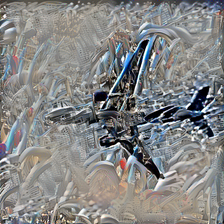

In [ ]:
dataset[0][0]

In [ ]:
# now setup a dataloader to pass images through the model
transform = transforms.Compose([
  transforms.Resize(224),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderInstance('./texture_vs_shape/stimuli/style-transfer-preprocessed-512',
                              transform=transform)
dataset

Dataset ImageFolderInstance
    Number of datapoints: 1280
    Root location: ./texture_vs_shape/stimuli/style-transfer-preprocessed-512
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
dataloader

In [ ]:
for img,label,index in dataloader:
  break
print(img.shape), print(index)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 3, 224, 224])
tensor([0])


(None, None)

## Compute texture bias

We want to pass those images through a network trained on imagenet classificaiton, which maps images to 1000 classes. rgeirhos provides code that then maps those 1000 classes down to the 16 he used (airplane, bear, etc.). 

1. Evaluate your models on all 1,280 images here (https://github.com/rgeirhos/texture-vs-shape/tree/master/stimuli/style-transfer-preprocessed-512).
2. Map model decisions to 16 classes 
3. Exclude images without a cue conflict (e.g. texture=cat, shape=cat).
Take the subset of "correctly" classified images (either shape or texture category correctly predicted).
4. Compute "shape bias" as the following fraction: (correct shape decisions) / (correct shape decisions + correct texture decisions).

In [ ]:
import torch 
import torchvision 
from fastprogress.fastprogress import progress_bar 
from IPython.core.debugger import set_trace 
from texture_vs_shape.code.probabilities_to_decision import ImageNetProbabilitiesTo16ClassesMapping

mapping = ImageNetProbabilitiesTo16ClassesMapping()

def compute_shape_bias(model, dataloader):
  # use the GPU if available
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model.to(device)
  model.eval()

  filenames = [Path(name).name for name,label in dataloader.dataset.imgs]
  correct_class_names = [parse_filename(filename) for filename in filenames]
  correct_shape_decisions = 0.
  correct_texture_decisions = 0.

  with torch.no_grad():
    for img,label,index in progress_bar(dataloader):
      
      # get model ouput
      output = model(img.to(device))

      # compute softmax
      softmax = torch.nn.functional.softmax(output,dim=1).detach().cpu()

      # map decision to 16 classes
      decision_from_16_classes = mapping.probabilities_to_decision(softmax.squeeze().numpy())  

      # compute accuracy
      correct_shape, correct_texture = correct_class_names[index]

      # skip if shape and texture agree (no cue-conflict for these!)
      if correct_shape == correct_texture: 
        continue 
      
      if correct_shape == decision_from_16_classes:
        correct_shape_decisions += 1

      if correct_texture == decision_from_16_classes:
        correct_texture_decisions += 1

  shape_bias = (correct_shape_decisions) / (correct_shape_decisions + correct_texture_decisions)

  print(f"Shape Bias: {shape_bias}")

  return shape_bias

def remove_digits(s):
  return ''.join([i for i in s if not i.isdigit()])

def parse_filename(filename):
  class1, class2 = filename.split("-")
  class1 = remove_digits(class1)
  class2 = remove_digits(class2).split(".")[0]
  return class1,class2    

# AlexNet trained on ImageNet

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
shape_bias = compute_shape_bias(model, dataloader)

Shape Bias: 0.23941798941798942


# AlexNet trained on "Stylized ImageNet"

In [ ]:
from texture_vs_shape.models.load_pretrained_models import load_model

model = load_model('alexnet_trained_on_SIN')
shape_bias = compute_shape_bias(model, dataloader)

Using the AlexNet architecture.


Shape Bias: 0.7669902912621359


# Resnet50 Trained on ImageNet

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
shape_bias = compute_shape_bias(model, dataloader)

Shape Bias: 0.2139240506329114


# Resnet50 trained on "Stylized ImageNet"

In [ ]:
model = load_model('resnet50_trained_on_SIN')
shape_bias = compute_shape_bias(model, dataloader)

Using the ResNet50 architecture.


Shape Bias: 0.8136729222520107
